# Classification of Dogs vs Cats with PyTorch
This project is about building, training and deployment of a Deep Learning Image Classifier model that classifies whether the object in an image is dog or cat, using Pytorch with the AWS SageMaker SDK. Hyperparameter Tuner is used to search for optimal model parameters and then an Estimator is created with them to finetune a pretrained model, which is then deployed and used for inference.

In [2]:
# Install any packages that you might need
!pip install smdebug
!pip install torchvision --no-cache-dir
!pip install torch --no-cache-dir
!pip install kaggle

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)


In [3]:
# Import any packages that you might need
import sagemaker
import boto3
from sagemaker.session import Session
from sagemaker import get_execution_role
import os
import re
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
import IPython
from PIL import Image
import torch
import json
from IPython import display
import numpy as np
from torchvision import datasets, transforms
import shutil
import re

[2021-12-28 21:02:34.266 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:22 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


## Dataset

In [ ]:
# Fetch and upload the data to AWS S3
session = sagemaker.Session()

role = sagemaker.get_execution_role()

bucket= session.default_bucket()

os.environ["DEFAULT_S3_BUCKET"] = bucket

!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "user"
kaggle_key = "key"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))
 
!kaggle competitions download -c dogs-vs-cats
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o dogs-vs-cats.zip -d dogs-vs-cats

!unzip -o dogs-vs-cats/train.zip -d dogs-vs-cats/
#!unzip -o dogs-vs-cats/test1.zip -d dogs-vs-cats/
##!mv dogs-vs-cats/test1 dogs-vs-cats/test
    
!mkdir -p dogs-vs-cats/val/dogs
!mkdir -p dogs-vs-cats/val/cats
!mkdir -p dogs-vs-cats/train/dogs 
!mkdir -p dogs-vs-cats/train/cats
train_dir = "./dogs-vs-cats/train"
train_dogs_dir = f'{train_dir}/dogs'
train_cats_dir = f'{train_dir}/cats'
val_dir = "./dogs-vs-cats/val"
val_dogs_dir = f'{val_dir}/dogs'
val_cats_dir = f'{val_dir}/cats'

files = os.listdir(train_dir)
# Move a subset (600) of train cat and dog images their respective folder
cats_count = 0
dogs_count = 0
for f in files:
    if os.path.isfile(os.path.join(train_dir,f)):
        catSearchObj = re.search("cat", f)
        dogSearchObj = re.search("dog", f)
        TargetedSearchObj = re.search("5\d\d\d", f) 
        if (catSearchObj and (cats_count < 600) and TargetedSearchObj):
            shutil.move(f'{train_dir}/{f}', f'{train_cats_dir}/{f}')
            cats_count += 1
        elif (dogSearchObj and (dogs_count < 600) and TargetedSearchObj):
            shutil.move(f'{train_dir}/{f}', f'{train_dogs_dir}/{f}')
            dogs_count += 1
            #!mv os.path.join(train_dir,f) train_dogs_dir
# Delete bad data
os.rmdir('dogs-vs-cats/train/cats/.ipynb_checkpoints')

# move a subset of the training dataset to the validation datasets (100) for each category
cats_count = 0
dogs_count = 0
files = os.listdir(train_dogs_dir)
for f in files:
    if (cats_count < 100):
        shutil.move(f'{train_dogs_dir}/{f}', val_dogs_dir)
        cats_count += 1

files = os.listdir(train_cats_dir)
for f in files:
    if (dogs_count < 100):
        shutil.move(f'{train_cats_dir}/{f}', val_cats_dir)
        dogs_count += 1

os.environ["DEFAULT_S3_BUCKET"] = bucket

!aws s3 sync ./dogs-vs-cats/train/cats s3://${DEFAULT_S3_BUCKET}/image_classification/dogs-vs-cats/train/cats
!aws s3 sync ./dogs-vs-cats/train/dogs s3://${DEFAULT_S3_BUCKET}/image_classification/dogs-vs-cats/train/dogs
!aws s3 sync ./dogs-vs-cats/val s3://${DEFAULT_S3_BUCKET}/image_classification/dogs-vs-cats/val

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  dogs-vs-cats.zip
  inflating: dogs-vs-cats/sampleSubmission.csv  
  inflating: dogs-vs-cats/test1.zip  
  inflating: dogs-vs-cats/train.zip  
Archive:  dogs-vs-cats/train.zip
   creating: dogs-vs-cats/train/
  inflating: dogs-vs-cats/train/cat.0.jpg  
  inflating: dogs-vs-cats/train/cat.1.jpg  
  inflating: dogs-vs-cats/train/cat.10.jpg  
  inflating: dogs-vs-cats/train/cat.100.jpg  
  inflating: dogs-vs-cats/train/cat.1000.jpg  
  inflating: dogs-vs-cats/train/cat.10000.jpg  


## Hyperparameter Tuning
 This is the part where we will finetune a pretrained model with hyperparameter tuning. The hyperparameters optimized are learning-rate, batch-size and epochs.

In [4]:
# Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([128, 256]),
    "epochs": IntegerParameter(2, 4)
}

# Defining the objective metric (average test loss) and how to optimize it (Minimize)
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [
    {"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"},
    {"Name": "trainging loss", "Regex": "Loss: ([0-9\\.]+)"},
    {"Name": "test accuracy", "Regex": "Accuracy: ([0-9\\.]+)"}
]

In [8]:
# Create a Hyperparameter Tuner estimator for your HPs
estimator = PyTorch(
    entry_point="train_model.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=4,
    objective_type=objective_type,
) 

In [ ]:
# Fit your HP Tuner
tuner.fit()

In [20]:
# Get the best estimators
best_estimator = tuner.best_estimator()

# Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2021-12-27 08:46:46 Starting - Preparing the instances for training
2021-12-27 08:46:46 Downloading - Downloading input data
2021-12-27 08:46:46 Training - Training image download completed. Training in progress.
2021-12-27 08:46:46 Uploading - Uploading generated training model
2021-12-27 08:46:46 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"256"',
 'epochs': '4',
 'lr': '0.00880250473982069',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2021-12-27-08-21-09-678"',
 'sagemaker_program': '"train_model.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-153440404191/pytorch-training-2021-12-27-08-21-09-678/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging

In [4]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

In [5]:
# Create and fit an estimator using the best hyperparameters combination
best_hyperparameters = {'epochs': 4, 'batch-size': 256, 'lr': 0.00880250473982069}
estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.g4dn.2xlarge",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

estimator.fit(wait=True)

2021-12-28 21:02:57 Starting - Starting the training job...
2021-12-28 21:03:00 Starting - Launching requested ML instancesLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2021-12-28 21:04:28 Starting - Preparing the instances for training......
2021-12-28 21:05:28 Downloading - Downloading input data...
2021-12-28 21:05:48 Training - Downloading the training image.......................bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-12-28 21:09:44,750 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-12-28 21:09:44,769 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-12-28 21:09:44,777 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-12-28 2

In [6]:
# Plot a debugging output.
session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

Training jobname: pytorch-training-2021-12-28-21-02-57-026
Region: us-east-1
[2021-12-28 21:15:40.611 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:22 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-807116804612/pytorch-training-2021-12-28-21-02-57-026/debug-output
[2021-12-28 21:15:40.930 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:22 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-12-28 21:15:41.957 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:22 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.bias', 'gradient/ResNet_fc.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.0.relu_input_2', 'layer2.1.relu_inp

In [7]:
# Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-807116804612/pytorch-training-2021-12-28-21-02-57-026/rule-output


## Model Deploying

In [8]:
# Deploy your model to an endpoint
# from sagemaker.predictor import Predictor
# predictor = Predictor('pytorch-training-2021-12-27-19-48-46-827')
predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium") # TODO: Add your deployment configuration like instance type and number of instances

--------------!

## Inference

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  dogs dogs dogs cats
Predicted:  dogs dogs dogs cats


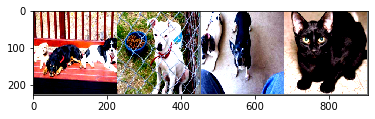

In [30]:
# Run an prediction on the endpoint
def create_data_loaders(data, batch_size):
    '''
    This is an optional function that you may or may not need to implement
    depending on whether you need to use data loaders or not
    '''
    return torch.utils.data.DataLoader(
        data,
        batch_size=batch_size,
        shuffle=True
    )

def imshow(img):
    import numpy as np
    import matplotlib.pyplot as plt
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

testset = datasets.ImageFolder(os.path.join('dogs-vs-cats', "val"), transforms.Compose(
    [   
        transforms.Resize(size=(256, 256)),
        transforms.CenterCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
))
testloader = create_data_loaders(testset, 4)
dataiter = iter(testloader)
images, labels = dataiter.next()
image = np.array([image], dtype=np.float32)
outputs = predictor.predict(images)
_, predicted = torch.max(torch.from_numpy(np.array(outputs)), 1)

import torchvision
imshow(torchvision.utils.make_grid(images))
classes = ("cats", "dogs")
print("GroundTruth: ", " ".join("%4s" % classes[labels[j]] for j in range(4)))
                                       
print("Predicted: ", " ".join("%4s" % classes[predicted[j]] for j in range(4)))

In [52]:
# Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()